# Sample output

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
# import statsmodels.api as sm
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
from matplotlib.dates import MO, WeekdayLocator
import random
from dataclasses import dataclass
import dataclasses
import re
import scipy.stats

coef = 100
the_default = "tmtc"
myFmt = mdates.DateFormatter('%m-%d')
project = "Montreux 2022 - do it together water quality sampling"
site_markers = {"svt":"o", "vnx":"D", "mrd":"X"}
species_colors = { "bioindicator":"dodgerblue", "coliform":"magenta"}
marker_colors = {"svt":"black", "vnx":"green", "mrd":"goldenrod"}
sites = ["svt", "vnx", "mrd"]

# important dates
f_start = dt.date(2022, 7, 1)
f_end = dt.date(2022, 7, 16)
post_season = dt.date(2022, 9, 12)

rain_data = pd.read_csv("data/sampledata/MCBP2022_rain_12oct22.csv")

survey_data = pd.read_csv("data/sampledata/long_work_data.csv")
survey_data["date"] = pd.to_datetime(survey_data["date"])
survey_data["count"] = survey_data["count"] * 100
survey_data["date"] = survey_data["date"].dt.date
type(survey_data["date"][0])
survey_data = survey_data[["site", "date", "plate-number", "category", "count", "week", "is-jazz"]]

In [2]:
def iso_standard_date(x):
    format = "%d.%m.%y"
    adate = dt.datetime.strptime(x, format).date()
    return adate
rain_data["DATE"] = rain_data["DATE"].map(lambda x:iso_standard_date(x))

In [3]:
def test_tries_fails(data, tries, priors: () = None):
    """Testing the condition data i > tries j  for all j in tries.
    
    Tries is defined by the min and the max of the data unless other wise specifed.    
    """ 
    
    tries_fails = {x:{"n":len(data), "k":0, "n-k":0} for x in tries}
    
    n = len(data)
    for result in data:
        for test in tries:            
            testing = [x for x in data if x > test]
            k = len(testing)
            n_minus_k = n - k           
            tries_fails[test]["k"] = k
            tries_fails[test]["n-k"] = n_minus_k
            # assume a uniform prior beta(a=1, b=1)
            if k == 0 and priors is None:
                k = k+1
                n_minus_k = n - k + 1
            # add priors
            else:
                k = k + priors["k"]
                n_minus_k = n_minus_k + priors["n_minus_k"]
                
            tries_fails[test].update({"beta":stats.beta(k, n_minus_k)})
    
    return tries_fails        

def get_tries_fails(d: [] = None, a_range: () = None, step: int = 10, priors: {} = {"k": 1, "n_minus_k": 1}):
    """Calculates the number and values to be tested. Passes the results to test_tries_fails"""
    
    if a_range is None:
        start, stop = np.amin(d), np.amax(d)
        print(start, stop)
        print(type(start), type(stop))
    else:
        start, stop = a_range
    
    assert start >= 0, "This should be an int"
    assert stop >= start, "This should be an int"
            
    tries = np.arange(start=start, stop=stop+step, step=step)
    tries_fails = test_tries_fails(d, tries, priors)
    
    return tries_fails

def test_hypothesis_0(
    data: pd.DataFrame = None, site: str = None, category: str = None, column: str = "count",
    tries: np.array = None, step: int = 10, priors: {} = {"k": 1, "n_minus_k": 1}) -> ():
    
    counts = get_these_counts(data=data, site=site, category=category, column=column)
    mean_std = get_mean_std(counts)
    min_max = get_min_max_(counts)
    tries_fails = get_tries_fails(d=counts, a_range=min_max, step=step)
    
    return counts, mean_std, min_max, tries_fails

@dataclass
class Observation:
    "One observation"
    date : dt.date = None
    site: str = None
    category: str = None
    count: int = None
    plate: int = None
    
    def __init__(self, date: dt.date = None, site: str = None, category: str = None, count: int = None, plate: int = None):
        self.date = date
        self.site = site
        self.count = count
        self.plate = plate
        self.category = category

@dataclass
class SpeciesClass:
    "A collection of observations of the same category"
    date : dt.date = None
    site: str = None
    category: str = None
    observations: list[Observation] = dataclasses.field(default_factory=list)
    avg_count = None
    std_dev = None
    n_plates: int = 0
    counts: list[int]  =  dataclasses.field(default_factory=list)
    tries_fails: dict = None
    
    def __init__(self, date: dt.date = None, site: str = None, category: site = None, observations: list[Observation] = None):
        self.date = date
        self.site = site
        self.category = category
        self.observations = observations
    
    # def __init_(self, date: str = None, site: str = None, category: str = None)
    
    def set_avg_count(self):
        
        self.avg_count = np.mean([x.count for x in self.observations])
    
    def set_std_of_count(self):
        self.std_dev = np.std([x.count for x in self.observations])
        
    def set_n_plates(self):
        self.n_plates = len(self.observations)        
   
        
    def set_tries_fails(self, tries: [], a_range: () = None, step: int = None, priors: dict = None):
        
        d = [x.count for x in counts]
        
        self.tries_fails = get_tries_fails(d=d, tries=tries, a_range=a_range, step=step, priors=priors)
        
    def __str__(self):
        astring = f"""{self.category}: plates={self.n_plates}, average={self.avg_count}, standard deviation= {self.std_dev}"""
        return astring
    
    def __repr__(self):
        astring = f"""{self.category}: plates={self.n_plates}, average={self.avg_count}, standard deviation= {self.std_dev}"""
        return astring
        
@dataclass   
class Sample:
    "A collection of SpeciesClasses from the same day and location"
    date : dt.date = None
    site: str = None
    is_jazz: bool = None
    week: int = None
        
    def __init__(self, date: dt.date = None,  site: str = None, is_jazz: str = None, week: int = None, n_plates: int = None, result: [] = None):
        self.date = date
        self.site = site
        self.is_jazz = is_jazz
        self.week = week
        self.n_plates = n_plates
        self.result = result    
    
    
    def __str__(self):
        astring = f"""
        Sample {self.site} on {self.date}. Week number {self.week}, is jazz {self.is_jazz}.
        
        """
        
        return astring
    
    def __repr__(self):
        astring = f"""
        Sample {self.site} on {self.date}. Week number {self.week}, is jazz {self.is_jazz}.
        
        """
        
        return astring

def make_observations(data):
    """The data is an nd array with at least seven columns. 
    
    :param site: str: The name of a sensor or survey location
    :param date: dt.date or str: The date of the record in %Y-%m=%d format
    :param plate: int: The replicant number of the observation, if there is only one use that
    :param category: str: A label or token for the observation
    :param count: int: The result of the observation
    :param obs: Observation: An Observation object
    
    """
    
    observations = []
    for row in data:
        site = row[0]
        date = row[1]
        plate = row[2]
        category = row[3]
        count = row[4]
        assert site is not None, "This should have a name"
        assert date is not None, "This should have a date"
        assert isinstance(date, dt.date), "This should be a date object"
        assert plate > 0, "There has to be at least one try"
        assert category is not None, "There should be something here"
        assert re.match(r'[a-zA-Z0-9_\-]+', category), "Only letters, numbers, hyphens and underscores"
        obs = Observation(date=date, site=site, plate=plate, category=category, count=count)
        observations.append(obs)
    
    return observations



def assign_observations_to_category(obs: Observation = None, cats: dict = None) -> dict:
    """Sorts the observations by category and assigns the values to an array
    
    The data is assumed to come from the same sample day or group. This means
    that numerical operations will be as if all values in the same category are
    discrete members of the same group. The parameter cats is assumed to have key values
    that have the same orgins as obs.category
    """
    
    a_cat = obs.category
    cats[a_cat]["observations"].append(obs)
    
def make_categories_from_observations(observations: list[Observation] = None, categories: [] = None, site: str = None, date: str = None,) -> ():
        
        f_json = {a_cat:dict(date=date, site=site, category=a_cat, observations=[]) for a_cat in categories}
        for obs in observations:
            obs.site = site
            obs.date = date
            assign_observations_to_category(obs=obs, cats=f_json)
            
            
        f_array = []
        for the_cat in f_json:
            data = [x.count for x in f_json[the_cat]["observations"]]
            a_mean = round(np.mean(data), 2)
            a_median = round(np.median(data), 2)
            a_std = round(np.std(data), 2)
            plates = len(data)
            row = [the_cat,site, date, a_mean, a_median, a_std, plates]
            f_array.append(row)
            
        return f_array, f_json
    
    
def make_species_class(data: dict = None, date: str = None):
    """Constructor method for the species class.
    
    The data dict MUST contain the necesary information to spin up a SpeciesClass AND
    call the set_avg_count and set_std_of_count methods.
    
    The data comes from the instances of Observation that are included in the args.
    Therefore the date and site attributes are for grouping and sorting operations.
    """    
    
    date=data["date"]
    category=data["category"]
    observations = data["observations"]
    site = data["site"]
    
    # make a class
    aclass = SpeciesClass(date=date, category=category, site=site, observations=observations)
    
    # iniate the required attributes    
    aclass.set_avg_count()
    aclass.set_std_of_count()
    aclass.n_plates = len(aclass.observations)
    aclass.counts = [x.count for x in aclass.observations]
    
    
    assert aclass.avg_count is not None, "There should be an average count"
    assert aclass.std_dev is not None, "There should be a standard deviation"
    assert aclass.n_plates > 0, "There has to be at least one plate"
    assert len(aclass.counts) > 1, "There should be at least one set of counts"
    
    
    return aclass    
    
    
def make_category_data(data: pd.DataFrame = None, site: str = None, date: str = None, cats: bool = True, out: str = "array"):
    """Makes the arguments necesary to create a SpeciesClass and creates the summary of results for that class.
    
    The two values f_array and args are the same data except one is in .JSON and the other is an np.array. The args get passed on to
    create a SpeciesClass instance.
    """
    
    if isinstance(date, str):
        date = dt.datetime.strptime(date, "%Y-%m-%d").date()    
    
    mask = (data["site"] == site)&(data["date"] == date)
    this_data = data[mask].copy()
    assert len(this_data) > 0, "There should be data here"
        
    observations = make_observations(this_data.values)
    assert len(observations) > 0, "There should be at least one observation"
    
    if cats:
        categories = this_data["category"].unique()
        f_array, args = make_categories_from_observations(observations=observations, categories=categories, date=date, site=site)   
   
        
    return args, f_array


def make_sample_class(data: pd.DataFrame = None, site: str = None, date: str = None, week: int = None, is_jazz: bool = None,cats: bool = True, out: str = "array"):
    """Sorts the observations and groups them according to category for each sample
    
    :return: A Sample class
    """
    
    h, i = make_category_data(data=data, site=site, date=date)
    assert h is not None, "This should still be good"
    assert i is not None, "Same here"
    assert len(h) > 0, "There should be some data in there"
    
    asample = Sample(date=date, site=site, week=week, is_jazz=is_jazz)
    results = []
    these_attributes = list(h.keys())
    for a_key in these_attributes:
        category_data = h[a_key]
        j = make_species_class(category_data)
        asample.__dict__.update({a_key:j})
        
    assert len([x for x in these_attributes if x not in asample.__dict__.keys()]) == 0, "All these attributes should be added"        
    # add the summary of results to the class instance
    asample.result = i
        
    return asample

def make_surveys(data):
    """Arranges the observations by category, date and groups them according to user definitions. Calls make_sample_class to organize
    the observations by category.
    
    :return: An array of survey objects with category results
    """
    data["ldid"] = list(zip(data["site"], data["date"]))
    # unique location date combinations:
    ldid = data.ldid.unique()

    surveys = []
    for an_ldid in ldid:
        args = data[data["ldid"] == an_ldid][["site", "date", "week", "is-jazz"]].values[0]
        j = make_sample_class(data=data, site=args[0], date=args[1], week=args[2], is_jazz=args[3])
       
        surveys.append(j)
        
    return surveys

def major_and_minor_ticks(ax):
    loc_major = WeekdayLocator(byweekday=MO, interval=1)
    ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))  
    ax.xaxis.set_major_locator(loc_major)
    ax.xaxis.set_major_formatter(myFmt)
    ax.tick_params(axis='x', labelrotation = 45)
    ax.tick_params(axis='x', which='major', length=8, width=2, color='r')
    
    return ax



  
class SampleGroup:
    
    label: str = None
    args: dict = None
    samples: list[Sample] = None
    n_samples: int = None
    n_sites: int = None
    sites: [] = None
    data_frame = None
    
    def __init__(self, label, args, samples, summary: dict = {}):
        self.label = label
        self.args = args
        self.samples = samples
        self.summary = summary
        self.survey_reults = None
        self.sites = None
        self.n_sites = None
        self.data_frame = None
        self.n_samples = None
    
    def set_n_samples(self):
        self.n_samples = len(self.samples)
    
    def set_n_sites(self):
        sites = {x.site for x in self.samples}
        self.n_sites = len(sites)
        self.sites = list(sites)
        
    def set_survey_results(self):
        flattened = []
        tables = [x.result for x in self.samples]
        for table in tables:
            flattened += table
        self.survey_results = flattened
        
    def set_data_frame(self):
        if self.survey_results is None:
            self.set_survey_results()
        columns = [
            "category", "site", "date",  "mean", "median", "std", "n"
        ]
        self.data_frame = pd.DataFrame(self.survey_results, columns=columns)
        
    def make_a_category_summary(self, d: list[Sample] = None, arg: str= None):
        """The mean, range, standard deviation and number of plates for the requested category from the sample group
        
        :param arg: The category of interest in the survey object
        
        """ 
        if d is None:
            d = self.samples
        # the samples needed
        g = [(x.__dict__[arg].n_plates, x.__dict__[arg].avg_count) for x in d]
        # goes right to a data frame
        df = pd.DataFrame(g, columns = ["plates", "average"])
        # calculate the weight of each observation
        df["weight"] = df["plates"]/df.plates.sum()
        # the standard deviation and weighted average
        wtd = np.average(df["average"], weights=df["weight"])
        variance = np.average((df["average"]-wtd)**2, weights=df["weight"])
        # collect the min max and n samples        
        amin, amax = df["average"].min(), df["average"].max()       
        samples = df.plates.sum()
        
        a_summary = dict(
                    weighted_av=round(wtd, 2),
                    std=round(np.sqrt(variance), 2),
                    a_min=round(amin, 2),
                    a_max=round(amax, 2),
                    n_samples = samples)

        return {arg: a_summary}
    
    def set_category_summaries(self):
        a_summary = {}
        for cat in self.args[1]:
            a = self.make_a_category_summary(arg=cat)
            assert a[cat] is not None, "hmm"
            a_summary.update(a)
            
        self.summary = a_summary
    
        
    def format_df_for_display_mean_std(self, category: str = None):
        if self.data_frame is None:
            self.set_data_frame()
        
        groups = ["site", "date", "category"]
        d = self.data_frame[[*groups, "mean", "std"]][self.data_frame["category"] == category]
        s = d[[*groups, "mean", "std"]].copy()
        s["std +"] = s["std"] + s["mean"]
        s["std -"] = s["mean"] - s["std"]
        s["std -"] = s["std -"].where( s["std -"]>=0, 0)
        
        return s
        
def scatter_plot_with_std(data: pd.DataFrame=None, label: str = None, x: str = None, y_one: str = None, y_two: str = None, y_three: str = None, ax: matplotlib.axes = None, color: str = None, marker: str = None):
    ax.vlines(x=data[x], ymin=data[y_one], ymax=data[y_three], color=color, alpha=.2, linestyle= "-.")
    sns.scatterplot(data = data, x=x, y=y_two, color=color, marker=marker, label=label, ax=ax)
    sns.scatterplot(data = data, x=x, y=y_three, color=color, label="mean + std", marker=7, ax=ax)
    sns.scatterplot(data = data, x=x, y=y_one, color=color,label="mean - std", marker=6, ax=ax)
    
    return ax

# make survey objects from the data
surveys = make_surveys(survey_data)

# assign surveys to groups (location and speciex)
# group surveys by site
by_site = {x:[] for x in survey_data.site.unique()}
for survey in surveys:
    by_site[survey.site].append(survey)

    # group surveys by category
by_category = {x:[] for x in survey_data.category.unique()}
for survey in surveys:
    by_category["bioindicator"].append(survey.bioindicator)
    by_category["coliform"].append(survey.coliform)
    by_category["turquoise"].append(survey.turquoise)
    

coi = ["bioindicator", "coliform"]

# sample_groups:
sample_groups = {}
for a_name in sites:
       
    a = SampleGroup(label=a_name, samples=by_site[a_name], args=(a_name, coi))
    a.set_n_samples()
    a.set_n_sites()
    a.set_survey_results()
    a.set_data_frame()
    a.set_category_summaries()
    sample_groups.update({a_name:a})

In [4]:
n_days = len(survey_data["date"].unique())
dy_loc = list(zip(survey_data["date"].values, survey_data["site"].values))
survey_data["ld"] = list(zip(survey_data["date"], survey_data["site"]))
ppd = survey_data.groupby(["category","date"])["plate-number"].sum()
total_plates = ppd.groupby("category").sum()

# plates per day
print(f"""
      \n
    Montreux Jazz festival: Do it together water quality monitoring
          \n
    number of sample days {n_days}
          \n
    number of samples {len(survey_data["ld"].unique())}
          \n      
    Total number of cards:
    \n
    {list(zip(total_plates.index, total_plates.values))}
      
      
      """)


      

    Montreux Jazz festival: Do it together water quality monitoring
          

    number of sample days 16
          

    number of samples 53
          
      
    Total number of cards:
    

    [('bioindicator', 826), ('coliform', 826), ('turquoise', 826)]
      
      
      


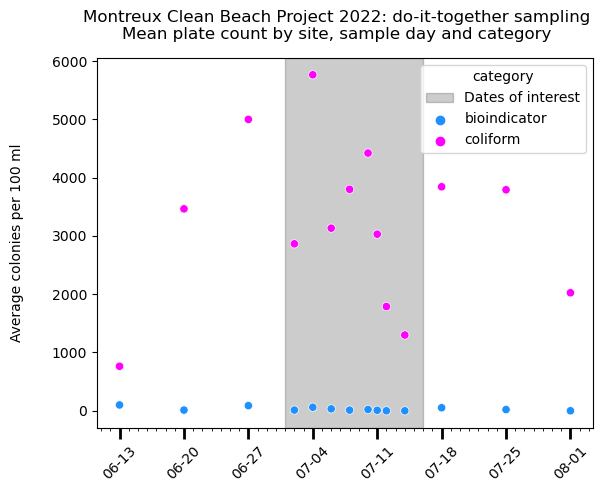

In [5]:
# mean per sample day and location
# set the index groups
groups = ["date", "category"]

this_data = survey_data[survey_data.category != "turquoise"].copy()
this_data = this_data[this_data["date"] <= dt.date(2022, 8, 1)]
mean_sample_day_location_category = this_data.groupby(groups, as_index=False)["count"].mean()
myFmt = mdates.DateFormatter('%m-%d')


fig, ax = plt.subplots()

title = "Mean plate count by site, sample day and category"
project = "Montreux Clean Beach Project 2022: do-it-together sampling"

def major_and_minor_ticks(ax):
    loc_major = WeekdayLocator(byweekday=MO, interval=1)
    ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))  
    ax.xaxis.set_major_locator(loc_major)
    ax.xaxis.set_major_formatter(myFmt)
    ax.tick_params(axis='x', labelrotation = 45)
    ax.tick_params(axis='x', which='major', length=8, width=2, color='black')
    
    return ax

ax.axvspan(f_start, f_end, color="black", alpha=0.2, label="Dates of interest")
sns.scatterplot(data = mean_sample_day_location_category, x="date", y="count", hue="category", palette=species_colors)

ax = major_and_minor_ticks(ax)
# ax.axvline(x=f_start, ymin=0, ymax=1)
# ax.axvline(x=f_end, ymin=0, ymax=1)
ax.set_ylabel("Average colonies per 100 ml", labelpad=20)
ax.set_xlabel("")

plt.suptitle(f"{project}\n{title}")

plt.show()

In [6]:
# mean per sample day and location
# set the index groups
# groups = ["date", "category"]

# this_data = survey_data[survey_data.category == "bioindicator"].copy()
# this_data = this_data[this_data["date"] <= dt.date(2022, 8, 1)]
# mean_sample_day_location_category = this_data.groupby(groups, as_index=False)["count"].mean()
# myFmt = mdates.DateFormatter('%m-%d')


# fig, ax = plt.subplots()

# title = "Mean plate count by site, sample day and category"
# project = "Montreux Clean Beach Project 2022: do-it-together sampling"

# def major_and_minor_ticks(ax):
#     loc_major = WeekdayLocator(byweekday=MO, interval=1)
#     ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))  
#     ax.xaxis.set_major_locator(loc_major)
#     ax.xaxis.set_major_formatter(myFmt)
#     ax.tick_params(axis='x', labelrotation = 45)
#     ax.tick_params(axis='x', which='major', length=8, width=2, color='black')
    
#     return ax

# ax.axvspan(f_start, f_end, color="black", alpha=0.2, label="Dates of interest")
# sns.scatterplot(data = mean_sample_day_location_category, x="date", y="count", hue="category", palette=species_colors)

# ax = major_and_minor_ticks(ax)
# # ax.axvline(x=f_start, ymin=0, ymax=1)
# # ax.axvline(x=f_end, ymin=0, ymax=1)
# ax.set_ylabel("Average colonies per 100 ml", labelpad=20)
# ax.set_xlabel("")
# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles, labels, loc="upper right")

# plt.suptitle(f"{project}\n{title}")

# plt.show()

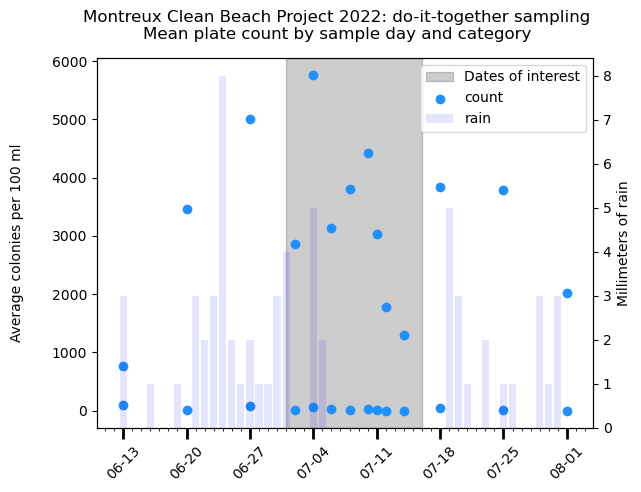

In [7]:
# mean per sample day and location
# set the index groups
# groups = ["date", "category"]

# this_data = survey_data[survey_data.category == "bioindicator"].copy()
# mean_sample_day_location_category = this_data.groupby(groups, as_index=False)["count"].mean()
# myFmt = mdates.DateFormatter('%m-%d')
rain_data.rename(columns={"Rainfall (mm)":"rain"} , inplace=True)
fig, ax= plt.subplots()

title = "Mean plate count by sample day and category"
project = "Montreux Clean Beach Project 2022: do-it-together sampling"
ax2 = ax.twinx()
def major_and_minor_ticks(ax):
    loc_major = WeekdayLocator(byweekday=MO, interval=1)
    ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))  
    ax.xaxis.set_major_locator(loc_major)
    ax.xaxis.set_major_formatter(myFmt)
    ax.tick_params(axis='x', labelrotation = 45)
    ax.tick_params(axis='x', which='major', length=8, width=2, color='black')
    
    return ax

ax.axvspan(f_start, f_end, color="black", alpha=0.2, label="Dates of interest")
ax.scatter(data = mean_sample_day_location_category, x="date", y="count", color="dodgerblue")
ax2.bar(data=rain_data, x = "DATE", height="rain", color="b", alpha=.1, label="rain") 



ax = major_and_minor_ticks(ax)
# ax.axvline(x=f_start, ymin=0, ymax=1)
# ax.axvline(x=f_end, ymin=0, ymax=1)
ax.set_ylabel("Average colonies per 100 ml", labelpad=20)
ax2.set_ylabel("Millimeters of rain")
ax.set_xlabel("")
ax2h, ax2l = ax2.get_legend_handles_labels()
rain_handle = ax2h[:1]
rain_label = ["rain"]
handles, labels = ax.get_legend_handles_labels()
ax.legend([*handles, *rain_handle], [*labels, *rain_label], loc="upper right")



plt.suptitle(f"{project}\n{title}")

plt.show()

In [8]:
svt = sample_groups["svt"]
vnx = sample_groups["vnx"]
mrd = sample_groups["mrd"]
averages = f"""
  \nThe weighted average and standard deviation of BIOINDICATORS at each location.\n
  SVT : {svt.summary["bioindicator"]}
  VNX : {vnx.summary["bioindicator"]}
  MRD : {mrd.summary["bioindicator"]}
    
  \nThe weighted average and standard deviation of COLIFORMS at each location.\n
  SVT : {svt.summary["coliform"]}
  VNX : {vnx.summary["coliform"]}
  MRD : {mrd.summary["coliform"]}
    """
print(averages)


  
The weighted average and standard deviation of BIOINDICATORS at each location.

  SVT : {'weighted_av': 39.19, 'std': 57.11, 'a_min': 0.0, 'a_max': 200.0, 'n_samples': 74}
  VNX : {'weighted_av': 19.4, 'std': 21.32, 'a_min': 0.0, 'a_max': 66.67, 'n_samples': 67}
  MRD : {'weighted_av': 34.29, 'std': 43.27, 'a_min': 0.0, 'a_max': 133.33, 'n_samples': 70}
    
  
The weighted average and standard deviation of COLIFORMS at each location.

  SVT : {'weighted_av': 4162.16, 'std': 3691.18, 'a_min': 520.0, 'a_max': 15733.33, 'n_samples': 74}
  VNX : {'weighted_av': 2970.15, 'std': 1170.61, 'a_min': 866.67, 'a_max': 4533.33, 'n_samples': 67}
  MRD : {'weighted_av': 3614.29, 'std': 2055.43, 'a_min': 1050.0, 'a_max': 7033.33, 'n_samples': 70}
    


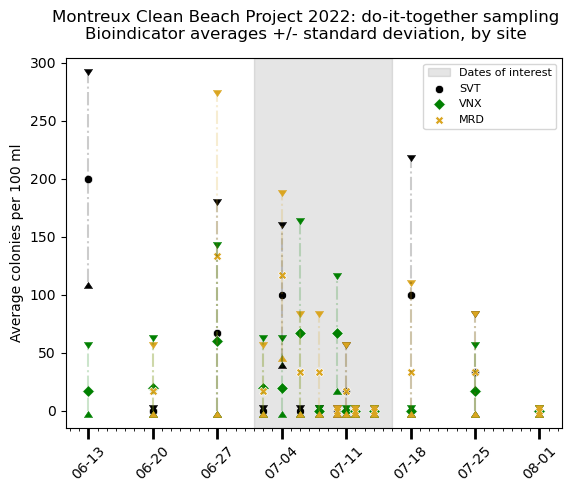

In [9]:
# bioindicator results
title = "Bioindicator averages +/- standard deviation, by site"
soi = "bioindicator"


fig, ax = plt.subplots()

# the shaded area of the jazz
ax.axvspan(f_start, f_end,  color="black", alpha=.1,  label="Dates of interest")

# the results from each location
for site in sites:
    data = sample_groups[site].format_df_for_display_mean_std(soi)
    data= data[data["date"] <= dt.date(2022, 8, 1)]
    ax = scatter_plot_with_std(**dict(data=data, label=site, x="date", y_one="std -", y_two="mean", y_three="std +", ax=ax, color=marker_colors[site], marker=site_markers[site]))


ax = major_and_minor_ticks(ax)
ax.set_ylabel("Average colonies per 100 ml")
ax.set_xlabel("")

handles, labels = ax.get_legend_handles_labels()
h = [handles[0], handles[1], handles[4], handles[7]]
ls = ["Dates of interest", "SVT", "VNX", "MRD"]
ax.get_legend().remove()

plt.suptitle(f"Montreux Clean Beach Project 2022: do-it-together sampling\n{title}", fontsize=12)
plt.legend(h, ls, loc="upper right", fontsize=8)

plt.show()


## 1. Are the plate counts for bioindicators durring the festival different than the counts before and after the festival?

### H<sub>0</sub>: E[count]<sub>jazz dates</sub> = E[count]<sub>other dates</sub> 
### H<sub>1</sub>: E[count]<sub>jazz dates</sub> $\neq$ E[count]<sub>other dates</sub>

If the expected value of the plate counts during the festival are within the 95% confidence interval of the plate counts before and after the festival then we assume that there was no difference between the three time periods.

In [10]:
# samples before the jazz
before_jazz = []
jazz = []
after_jazz = []

for site in sample_groups:
    data = sample_groups[site].samples
    for sample in data:
        if sample.is_jazz is True:
            jazz.append(sample)
        elif sample.is_jazz is False:
            if sample.week <= 3:
                before_jazz.append(sample)
            else:
                after_jazz.append(sample)
b_jazz = SampleGroup(label="Before jazz", samples=before_jazz, args=("before jazz",  ["bioindicator", "coliform"]))
time_groups = {}
labels = ["Before jazz", "Jazz", "After jazz"]
for i,a_list in enumerate([before_jazz, jazz, after_jazz]):   
       
    a = SampleGroup(label=labels[i], samples=a_list, args=(labels[i], coi))
    a.set_n_samples()
    a.set_n_sites()
    a.set_survey_results()
    a.set_data_frame()
    a.set_category_summaries()
    time_groups.update({labels[i]:a})
before_jazz = time_groups["Before jazz"]
jazz = time_groups["Jazz"]
after_jazz = time_groups["After jazz"]

time_stats = f"""
    \nThe weighted average, standard deviaton, min, max and number of samples by period:\n
    Before the jazz:
    {before_jazz.summary["bioindicator"]}
    \n
    During the jazz:
    {jazz.summary["bioindicator"]}
    \n
    After the jazz:
    {after_jazz.summary["bioindicator"]}
    
    """
print(time_stats)


    
The weighted average, standard deviaton, min, max and number of samples by period:

    Before the jazz:
    {'weighted_av': 75.0, 'std': 84.29, 'a_min': 16.67, 'a_max': 200.0, 'n_samples': 16}
    

    During the jazz:
    {'weighted_av': 25.0, 'std': 35.94, 'a_min': 0.0, 'a_max': 116.67, 'n_samples': 96}
    

    After the jazz:
    {'weighted_av': 30.3, 'std': 38.33, 'a_min': 0.0, 'a_max': 133.33, 'n_samples': 99}
    
    


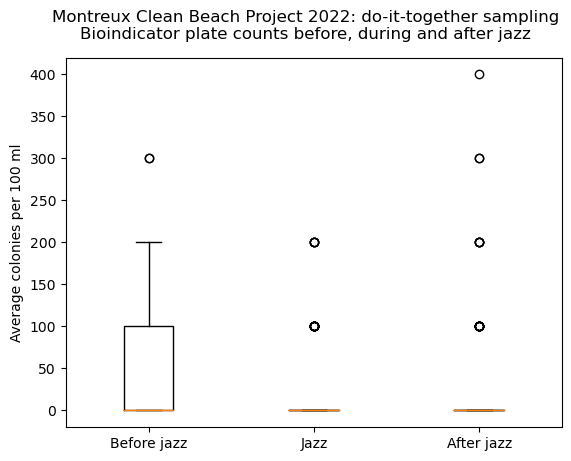

In [11]:
countsb = list(np.concatenate([x.bioindicator.counts for x in before_jazz.samples]))
countsd = list(np.concatenate([x.bioindicator.counts for x in jazz.samples]))
countsa = list(np.concatenate([x.bioindicator.counts for x in after_jazz.samples]))
data = [countsb, countsd, countsa]

title = "Bioindicator plate counts before, during and after jazz"
fig, ax = plt.subplots()

ax.boxplot(data)
ax.set_ylabel("Average colonies per 100 ml")
ax.set_xticklabels(labels)

plt.suptitle(f"{project}\n{title}", fontsize=12)
plt.show()

In [12]:
sd = survey_data.copy()
sd = sd[sd.category == "bioindicator"]

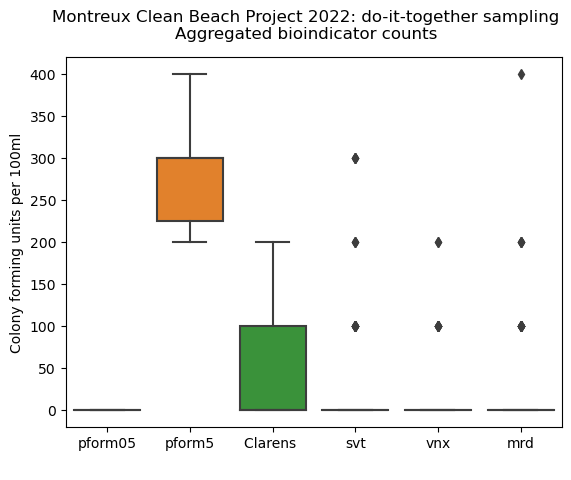

In [13]:
fig, ax = plt.subplots()
labels= ["half meter depth LéxP"]

sns.boxplot(data=sd, x="site", y="count", showfliers=True)
ax.set_ylabel("Colony forming units per 100ml")
ax.set_xlabel(" ")


plt.suptitle(f"{project}\nAggregated bioindicator counts", fontsize=12)
plt.show()